In [124]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from mordred import Calculator, descriptors

In [125]:
data_version_1_path = "../data_for_modeling/raw_data/v1/HDAC2_data_after_filtering_raw.xlsx"
data_version_2_path = "../data_for_modeling/raw_data/v2/Original Data - v2 - Merge.xlsx"
dataset = pd.read_excel(data_version_2_path, sheet_name='original_data')

In [126]:
dataset_length = len(dataset)
dataset_length

3214

# Tiền xử lý dữ liệu ban đầu

## 1. Profile of the data

## 1.1. Len with Activity

In [127]:
#Rows for specific labels
active_rows = dataset.loc[dataset['ACTIVITY'] == "Active"]
inactive_rows = dataset.loc[dataset['ACTIVITY'] == "Inactive"]
inconclusive_rows = dataset.loc[dataset['ACTIVITY'] == "Inconclusive"]
unspecified_rows = dataset.loc[dataset['ACTIVITY'] == "Unspecified"]

print("Total dataset")
table = [['', 'Active', 'Inactive', 'Inconclusive', 'Unspecified'], 
         ['Number', len(active_rows), len(inactive_rows), len(inconclusive_rows), len(unspecified_rows)],
         ['Percentage (%)', len(active_rows)/dataset_length*100, len(inactive_rows)/dataset_length*100,
          len(inconclusive_rows)/dataset_length*100, len(unspecified_rows)/dataset_length*100]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


Total dataset
╒════════════════╤═══════════╤════════════╤════════════════╤═══════════════╕
│                │    Active │   Inactive │   Inconclusive │   Unspecified │
╞════════════════╪═══════════╪════════════╪════════════════╪═══════════════╡
│ Number         │ 2243      │  15        │       97       │      858      │
├────────────────┼───────────┼────────────┼────────────────┼───────────────┤
│ Percentage (%) │   69.7884 │   0.466708 │        3.01805 │       26.6957 │
╘════════════════╧═══════════╧════════════╧════════════════╧═══════════════╛


## Find the incorrect numbers

### Based on number format

In [128]:
# Use to_numeric to identify non-float values
is_float = pd.to_numeric(dataset['IC50 (uM)'], errors='coerce').notna()
# Find the rows where 'IC50 (uM)' is not a float
non_float_rows = dataset[~is_float]
len(non_float_rows)

110

### Based on activity

In [129]:
#Find their activity
active_non_float_rows = non_float_rows.loc[non_float_rows['ACTIVITY'] == "Active"]
inactive_non_float_rows = non_float_rows.loc[non_float_rows['ACTIVITY'] == "Inactive"]
inconclusive_non_float_rows = non_float_rows.loc[non_float_rows['ACTIVITY'] == "Inconclusive"]
unspecified_non_float_rows = non_float_rows.loc[non_float_rows['ACTIVITY'] == "Unspecified"]
#len
len_anf = len(active_non_float_rows)
len_ianf = len(inactive_non_float_rows)
len_inf = len(inconclusive_non_float_rows)
len_unf = len(unspecified_non_float_rows)
#table with status 
table_nf_activity = [['', 'Active', 'Inactive', 'Inconclusive', 'Unspecified'], 
         ['Number', len_anf, len_ianf, len_inf, len_unf],
         ['Percentage (%)', len_anf/dataset_length*100, len_ianf/dataset_length*100,
          len_inf/dataset_length*100, len_unf/dataset_length*100]]

print(tabulate(table_nf_activity, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════╤══════════╤════════════╤════════════════╤═══════════════╕
│                │   Active │   Inactive │   Inconclusive │   Unspecified │
╞════════════════╪══════════╪════════════╪════════════════╪═══════════════╡
│ Number         │        0 │   8        │       97       │      5        │
├────────────────┼──────────┼────────────┼────────────────┼───────────────┤
│ Percentage (%) │        0 │   0.248911 │        3.01805 │      0.155569 │
╘════════════════╧══════════╧════════════╧════════════════╧═══════════════╛


### Nhãn mâu thuận

In [130]:
cid_active = active_rows.loc[:, 'CID']
cid_inactive = inactive_rows.loc[:, 'CID']
cid_incon = inconclusive_rows.loc[:, 'CID']
cid_unspec = unspecified_rows.loc[:, 'CID']
active_unspec_cid = np.intersect1d(cid_active, cid_unspec)
len(active_unspec_cid)

48

In [131]:
ac_inac_cid = np.intersect1d(cid_active, cid_inactive)
ac_incon_cid = np.intersect1d(cid_active, cid_incon)
ac_unspec_cid = np.intersect1d(cid_active, cid_unspec)

inac_incon_cid = np.intersect1d(cid_inactive, cid_incon)
incon_unspec_cid = np.intersect1d(cid_incon, cid_unspec)
inac_unspec_cid = np.intersect1d(cid_inactive, cid_unspec)
print(len(ac_inac_cid), 
      len(ac_incon_cid), 
      len(ac_unspec_cid), 
      len(inac_incon_cid), 
      len(incon_unspec_cid), 
      len(inac_unspec_cid))

0 9 48 2 2 2


## Get rid of the operators

In [132]:
def append_dataframe(dataframe, row):
    dataframe.loc[len(dataframe.index)] = [row['CID'], row['SMILES'],
                                            row['IC50 (uM)'], row['ACTIVITY']]

In [133]:
# Using NumPy
active_inactive_rows = pd.DataFrame(columns = dataset.columns)
invalid_rows = pd.DataFrame(columns= dataset.columns)

#Filter out unspecified
for cid in active_unspec_cid:
    rows = unspecified_rows[unspecified_rows.CID == cid]
    invalid_rows = pd.concat([invalid_rows, rows], ignore_index=False)
    unspecified_rows = unspecified_rows.drop(rows.index)
    
print("unspecified rows len after: " + str(len(unspecified_rows)) )

unspecified rows len after: 759


In [134]:
invalid_rows = pd.concat([invalid_rows, inconclusive_rows], ignore_index=False)
print(len(active_rows))
print(len(inactive_rows))
print(len(invalid_rows))

2243
15
196


### 3. Duplicate filter

In [135]:
final_columns = ["STT", "SMILES", "CID", "AVG_IC50_uM", "FIRST_LABEL", "FINAL_LABEL", "DUPLICATE_COUNTS"]
final_rows = pd.DataFrame(columns=final_columns)
stt = 0
for cid in active_rows.CID.unique():
    sub_dataset = active_rows.loc[active_rows.CID == cid]
    avg_ic50, dup_count = 0, 0
    for index, row in sub_dataset.iterrows():
        avg_ic50 = avg_ic50 + float(row["IC50 (uM)"])/len(sub_dataset)
        dup_count = dup_count + 1
    final_rows.loc[len(final_rows)] = [stt, row.SMILES, row.CID ,avg_ic50, 'Active',
                                        {True: 'Active', False: 'Inactive'} [avg_ic50 < 1],
                                        dup_count]
    stt = stt + 1

In [136]:
final_rows1 = pd.DataFrame(columns=final_columns)
for cid in inactive_rows.CID.unique():
    sub_dataset = inactive_rows.loc[inactive_rows.CID == cid]
    avg_ic50, dup_count = 0, 0
    for index, row in sub_dataset.iterrows():
        avg_ic50 = avg_ic50 + float(row["IC50 (uM)"])/len(sub_dataset)
        dup_count = dup_count + 1
    final_rows1.loc[len(final_rows1)] = [stt, row.SMILES, row.CID ,avg_ic50, 'Inactive',
                                        "Inactive",
                                        dup_count]

In [137]:
len(unspecified_rows)

759

In [138]:
final_rows2 = pd.DataFrame(columns=final_columns)
for cid in unspecified_rows.CID.unique():
    sub_dataset = unspecified_rows.loc[unspecified_rows.CID == cid]
    dup_count = 0
    for index, row in sub_dataset.iterrows():
        dup_count = dup_count + 1
    final_rows2.loc[len(final_rows2)] = [stt, row.SMILES, row.CID ,'', 'Unspecified',
                                        "Inactive",
                                        dup_count]

In [139]:
final_data_to_train = pd.DataFrame(columns=final_columns)
print("Before appends: " + str(len(final_data_to_train)))
final_data_to_train = pd.concat([final_data_to_train, final_rows], ignore_index=False)
final_data_to_train = pd.concat([final_data_to_train, final_rows1], ignore_index=False)
final_data_to_train = pd.concat([final_data_to_train, final_rows2], ignore_index=False)
print("After appends: " + str(len(final_data_to_train)))

Before appends: 0
After appends: 1829


## Cannocal Smile filter

In [140]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [141]:
Canon_SMILES = canonical_smiles(dataset.SMILES)
dataset['SMILES'] = Canon_SMILES
duplicates_smiles = final_data_to_train[final_data_to_train['SMILES'].duplicated()]['SMILES'].values

In [144]:
len(duplicates_smiles)
duplicates_smiles

array(['CN1C=C(C=N1)/C=C/C(=O)NC2=C(C=C(C=C2)F)N',
       'CC1=NC(=CO1)/C=C/C(=O)NC2=CC=CC=C2N'], dtype=object)

## Write to file

In [146]:
with pd.ExcelWriter("../data_for_modeling/filter_data/v2/HDAC2_data_after_filtering_raw_v2.xlsx") as writer:
    invalid_rows.to_excel(writer, sheet_name="invalid_data", index=False)
    final_data_to_train.to_excel(writer, sheet_name="final_data", index=False)

### Đánh giá bộ dữ liệu

In [ ]:
import matplotlib.pyplot as plt

# Define the data
labels = ['Active', 'Inactive']
values = [len(final_data_to_train.loc[final_data_to_train.FINAL_LABEL == "Active"]), len(final_data_to_train.loc[final_data_to_train.FINAL_LABEL == "Inactive"])]

# Create the bar chart
plt.bar(labels, values)

# Add labels on top of each column
for i, v in enumerate(values):
    plt.text(i, v + 10, str(v), ha='center')

# Set chart title and labels
plt.title('Number of samples based on their activity')
plt.xlabel('Status')
plt.ylabel('Number of Samples')

# Display the chart
plt.show()

AttributeError: 'DataFrame' object has no attribute 'FINAL_LABEL'

In [ ]:
dup_count_unique = final_data_to_train.DUPLICATE_COUNTS.unique()
dup_count_numbers = []
for dup_count_number in dup_count_unique:
    sub_dataset = final_data_to_train.loc[final_data_to_train.DUPLICATE_COUNTS == dup_count_number]
    dup_count_numbers.append(len(sub_dataset))
print(dup_count_unique)
print(dup_count_numbers)

[1 4 2 3 6 5 9 94 31]
[831, 5, 120, 27, 2, 4, 2, 1, 1]


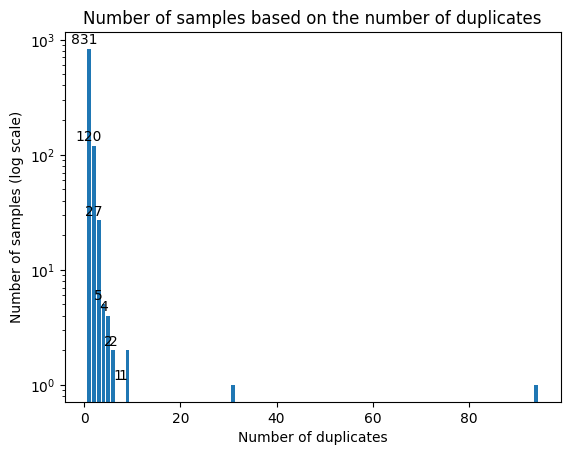

In [ ]:
import matplotlib.pyplot as plt

# Define the data
labels = [1, 4, 2, 3, 6, 5, 9, 94, 31]
values = [831, 5, 120, 27, 2, 4, 2, 1, 1]

# Sort the data by labels
labels, values = zip(*sorted(zip(labels, values)))

# Create the bar chart with log scale
plt.bar(labels, values)
plt.yscale('log')

# Add labels on top of each column
for i, v in enumerate(values):
    plt.text(i, v * 1.1, str(v), ha='center')

# Set chart title and labels
plt.title('Number of samples based on the number of duplicates')
plt.xlabel('Number of duplicates')
plt.ylabel('Number of samples (log scale)')

# Display the chart
plt.show()